In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

In [3]:
df = yf.Ticker('NQ=F')
df = df.history(start='2010-01-01', end='2024-01-01')
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04 00:00:00-05:00,1865.50,1889.00,1865.50,1886.75,205157,0.0,0.0
2010-01-05 00:00:00-05:00,1886.50,1890.25,1876.00,1885.25,208698,0.0,0.0
2010-01-06 00:00:00-05:00,1885.25,1891.75,1872.25,1878.50,261274,0.0,0.0
2010-01-07 00:00:00-05:00,1877.75,1880.50,1865.75,1877.50,241321,0.0,0.0
2010-01-08 00:00:00-05:00,1877.50,1892.50,1865.00,1890.00,268934,0.0,0.0


### Calcular medias móviles

In [4]:
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()

### Definir las reglas de entrada y salida

In [5]:

df['Signal'] = 0
df.loc[df['SMA_50'] > df['SMA_200'], 'Signal'] = 1 # Compra, cuando la EMA50 esta por encima de 200
df.loc[df['SMA_50'] < df['SMA_200'], 'Signal'] = -1 # venta, cuando la EMA50 esta por de bajo de 200

### Simular la ejecución de las órdenes


In [6]:
df['Position'] = df['Signal'].shift() # Simular la ejecuciòn al siguiente día
df['Strategy_Returns'] = df['Position'] * df['Close'].pct_change() # Retornos de la estrategia

In [7]:
df.dropna(inplace=True)

- df['Close'].pct_change(): Calcula el cambio porcentual diario del precio de cierre.

    -Si un precio cambia de 100 a 102, el cambio porcentual es (102 - 100) / 100 = 0.02 o 2%.
- Sumar 1: (df['Close'].pct_change() + 1)

    - Convertimos el cambio porcentual a un factor multiplicativo. Por ejemplo:
    Un cambio de 2% → 1 + 0.02 = 1.02 (ganancia del 2%).
    Un cambio de -1% → 1 - 0.01 = 0.99 (pérdida del 1%).

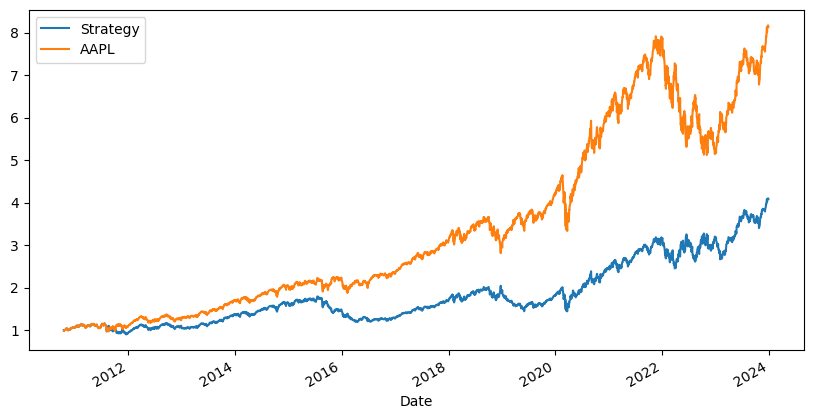

In [8]:
(df['Strategy_Returns'] + 1).cumprod().plot(label='Strategy', figsize=(10,5))
(df['Close'].pct_change() + 1).cumprod().plot(label='AAPL')
plt.legend()
plt.show()

Conclusión, es mejor holdear el activo que aplicar la estrategia de compra y venta en los periodos de EMA50, y EMA200

### Rendimiento anualizado

1. df['Strategy_Returns'] + 1: Convierte cada retorno en un factor multiplicativo:

    Ejemplo:
    Un retorno diario del 1% → 1 + 0.01 = 1.01.
    Una pérdida del 0.2% → 1 - 0.002 = 0.998.


2. prod(): Calcula el producto acumulado de todos los factores multiplicativos.

    Esto nos da el rendimiento compuesto total desde el inicio hasta el final del período.
    
    Ejemplo: Factores diarios: [1.01, 0.998, 1.02]
    Rendimiento compuesto = 1.01 * 0.998 * 1.02 ≈ 1.027 (2.7% de ganancia total).

3. - 1: Convierte el producto acumulado en el rendimiento total:

    Si el rendimiento compuesto acumulado es 1.27, entonces:
    
    total_return = 1.27 - 1 = 0.27 (27% de ganancia total).

In [9]:
total_return = (df['Strategy_Returns']+1).prod()-1
annualized_return = (1+total_return) ** (252/len(df)) - 1 # Ajustado por 252 días de trading anuales (días habiles promedios al año)

In [10]:
print(f'Rendimiento Anualizado: {annualized_return:.2%}')
print(f'Rendimiento Total: {total_return:.2%}')

Rendimiento Anualizado: 11.26%
Rendimiento Total: 308.13%


### Ratio De sharpe

El Ratio de Sharpe es una métrica clave en finanzas que mide el rendimiento ajustado por riesgo de una estrategia o inversión.

Supongamos que la tasa libre de riesgo (como los bonos del gobierno) es del 1% anual.

In [11]:
risk_free_rate = 0.01 # Supongamos que la tasa libre de riesgo es del 1%
excess_return = df['Strategy_Returns'].mean() - (risk_free_rate / 252) # Retornos en exceso sobre la tasa libre de riesgo
sharpe_ratio = excess_return / df['Strategy_Returns'].std()
print(f'Ratio de Sharpe: {sharpe_ratio:.2f}')

Ratio de Sharpe: 0.04


### Interpretación del Ratio de Sharpe: 0.04
1. **Bajo Ratio de Sharpe:**

- Un Sharpe Ratio de 0.04 es muy bajo, indicando que la estrategia no está generando suficiente rendimiento en comparación con el riesgo asumido.
- En general, se considera que:
    - Sharpe Ratio < 1: Bajo.
    - Sharpe Ratio entre 1 y 2: Aceptable.
    - Sharpe Ratio > 2: Excelente.
2. **Posible causa del bajo ratio:**

- Aunque la estrategia genera rendimientos positivos, estos pueden ser pequeños en comparación con su volatilidad.
- En la gráfica, observamos que la estrategia es menos rentable que el activo subyacente, lo que explica un bajo Ratio de Sharpe.

### Máximo Drawdown
Es una métrica fundamental para evaluar el riesgo de una estrategia de inversión. Representa la pérdida máxima acumulada desde un pico hasta un valle en el rendimiento acumulativo. 

1. cummax calcula el valor máximo acumulado a lo largo del tiempo.
Representa el punto más alto alcanzado por la estrategia en cualquier momento.

In [12]:
df['Cumulative_Returns'] = (df['Strategy_Returns'] + 1).cumprod()
df['Peak'] = df['Cumulative_Returns'].cummax()
df['Drawdown'] = (df['Cumulative_Returns'] - df['Peak']) / df['Peak']
max_drawdown = df['Drawdown'].min()
print(f'Máximo Drawdown: {max_drawdown:.2%}')

Máximo Drawdown: -33.20%


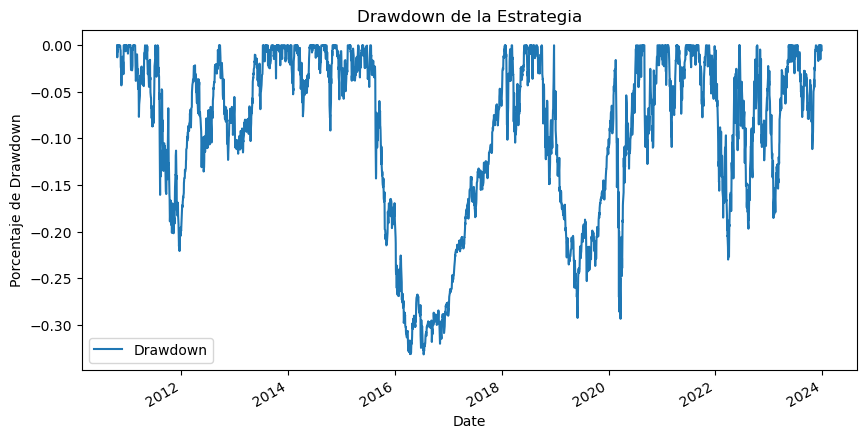

In [13]:
plt.figure(figsize=(10, 5))
df['Drawdown'].plot(label='Drawdown')
plt.title('Drawdown de la Estrategia')
plt.ylabel('Porcentaje de Drawdown')
plt.legend()
plt.show()


Qué significa:

En algún momento del período analizado, la estrategia experimentó una pérdida acumulada del 33.20% desde su punto máximo hasta su punto más bajo.
Esto indica la peor caída en el rendimiento de la estrategia.

### Ratio de Ganancias/Pérdidas


In [14]:
winning_trades = df[df['Strategy_Returns'] > 0]['Strategy_Returns'].count()
losing_trades = df[df['Strategy_Returns'] <=0]['Strategy_Returns'].count()

win_loss_ratio = winning_trades / losing_trades if losing_trades != 0 else np.inf

ganancia_media = df[df['Strategy_Returns'] > 0]['Strategy_Returns'].mean()
perdida_media = df[df['Strategy_Returns'] <= 0]['Strategy_Returns'].mean()

print(f'Operaciones Ganadores: {winning_trades} -- Ganancia Media: {ganancia_media:.2%}')
print(f'Operaciones Perdedoras: {losing_trades} -- Pérdida Media: {perdida_media:.2%}')
print(f'Ratio Ganancias/Pérdidas: {win_loss_ratio:.2f}')

Operaciones Ganadores: 1834 -- Ganancia Media: 0.86%
Operaciones Perdedoras: 1488 -- Pérdida Media: -0.95%
Ratio Ganancias/Pérdidas: 1.23


### Incorporando Costos Operativos: Comisiones y Slippage
### Simular comisiones y slippage (costos fijos y slippage como porcentaje del precio)

In [15]:
commission = 0.001  # 0.1% por transacción
slippage = 0.0005  # 0.05% de slippage por transacción

In [17]:
df['Transaction_Cost'] = df['Signal'].diff().abs() * (commission + slippage)
df['Net_Strategy_Returns'] = df['Strategy_Returns'] - df['Transaction_Cost']
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_50,SMA_200,Signal,Position,Strategy_Returns,Cumulative_Returns,Peak,Drawdown,Transaction_Cost,Net_Strategy_Returns
Date,,,,,,,,,,,,,,,,,
2010-10-18 00:00:00-04:00,2095.0,2104.75,2082.75,2094.50,254281,0.0,0.0,1919.986599,1888.021899,1,0.0,-0.000000,1.000000,1.000000,0.000000,NaN,NaN
2010-10-19 00:00:00-04:00,2092.0,2103.00,2051.50,2067.50,474153,0.0,0.0,1923.061599,1888.925649,1,1.0,-0.012891,0.987109,1.000000,-0.012891,0.0,-0.012891
2010-10-20 00:00:00-04:00,2068.0,2098.50,2062.50,2083.75,288963,0.0,0.0,1926.806599,1889.918149,1,1.0,0.007860,0.994868,1.000000,-0.005132,0.0,0.007860
2010-10-21 00:00:00-04:00,2085.0,2104.50,2066.75,2080.00,327967,0.0,0.0,1931.651599,1890.925649,1,1.0,-0.001800,0.993077,1.000000,-0.006923,0.0,-0.001800
2010-10-22 00:00:00-04:00,2080.5,2104.50,2077.00,2104.00,206996,0.0,0.0,1937.186599,1892.058149,1,1.0,0.011538,1.004536,1.004536,0.000000,0.0,0.011538
